In [1]:
import sys
import os

current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.append(project_root)

import numpy as np
import matplotlib.pyplot as plt
import torch

from tiingo_data.download_data import get_daily_returns_data_cached
from utils import get_device
from core.data import create_multivariate_windows, train_val_split, prepare_data_for_chronos
from core.eval import (
    run_chronos_sliding_backtest,
    summarize_backtest_results,
    evaluate_model_on_test,
    compare_models,
)
from chronos import Chronos2Pipeline

In [2]:
# Load and prepare data
df_all = get_daily_returns_data_cached()
df_train_clean, df_eval_clean = prepare_data_for_chronos(df_all, test_size=1200)

print(f"Training data shape: {df_train_clean.shape}")
print(f"Eval data shape: {df_eval_clean.shape}")

# Hyperparameters
context_length = 200
prediction_length = 1
stride = 50
learning_rate = 1e-5
num_steps = 1000
batch_size = 32

# Create multivariate windows (all stocks grouped together)
all_inputs = create_multivariate_windows(
    df_train_clean,
    context_length=context_length,
    prediction_length=prediction_length,
    stride=stride,
)
print(f"Total training windows: {len(all_inputs)}")
print(f"Each window shape: {all_inputs[0]['target'].shape}")

# Train/validation split
train_inputs, val_inputs = train_val_split(all_inputs, val_ratio=0.1)
print(f"Train samples: {len(train_inputs)}, Val samples: {len(val_inputs)}")

# Load model
pipeline = Chronos2Pipeline.from_pretrained(
    "amazon/chronos-2",
    device_map=get_device(),
    dtype=torch.float32,
)

print(f"Model device: {pipeline.model.device}")
print(f"Model dtype: {next(pipeline.model.parameters()).dtype}")

Training data shape: (2797, 114)
Eval data shape: (1200, 114)
Total training windows: 52
Each window shape: (114, 201)
Train samples: 46, Val samples: 6
Model device: mps:0
Model dtype: torch.float32


In [3]:
# Evaluate BASE model (zero-shot) BEFORE fine-tuning
print("Evaluating zero-shot model on test set...")
baseline_results = evaluate_model_on_test(
    pipeline=pipeline,
    df_test=df_eval_clean,
    context_length=context_length,
    n_samples=100,
)

print("\n=== ZERO-SHOT (Before Fine-tuning) ===")
print(f"Mean Quantile Loss: {baseline_results['mean_quantile_loss']:.6f} ± {baseline_results['std_quantile_loss']:.6f}")
print(f"Mean MSE: {baseline_results['mean_mse']:.6f}")
print(f"Mean MAE: {baseline_results['mean_mae']:.6f}")

Evaluating zero-shot model on test set...

=== ZERO-SHOT (Before Fine-tuning) ===
Mean Quantile Loss: 0.007240 ± 0.004854
Mean MSE: 0.000557
Mean MAE: 0.016263


In [4]:
# Fine-tune: model learns cross-stock patterns via group attention
finetuned = pipeline.fit(
    inputs=train_inputs,
    validation_inputs=val_inputs,
    prediction_length=prediction_length,
    context_length=context_length,
    min_past=context_length,
    num_steps=num_steps,
    batch_size=batch_size,
    learning_rate=learning_rate,
    output_dir="outputs/chronos2_multivariate",
)

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,0.522500,0.427287
200,0.494300,0.448865
300,0.377800,0.532006
400,0.322900,0.567771
500,0.279500,0.569958
600,0.233700,0.580568
700,0.232700,0.588949
800,0.206000,0.607184
900,0.189400,0.609273
1000,0.174500,0.614609


In [5]:
# Evaluate FINE-TUNED model AFTER training
print("Evaluating fine-tuned model on test set...")
finetuned_results = evaluate_model_on_test(
    pipeline=finetuned,
    df_test=df_eval_clean,
    context_length=context_length,
    n_samples=100,
)

print("\n=== FINE-TUNED (After Training) ===")
print(f"Mean Quantile Loss: {finetuned_results['mean_quantile_loss']:.6f} ± {finetuned_results['std_quantile_loss']:.6f}")
print(f"Mean MSE: {finetuned_results['mean_mse']:.6f}")
print(f"Mean MAE: {finetuned_results['mean_mae']:.6f}")

# Comparison using imported function
comparison = compare_models(baseline_results, finetuned_results)

print("\n=== COMPARISON ===")
print(f"Quantile Loss: {comparison['quantile_loss_improvement']:+.2f}% {'(better)' if comparison['quantile_loss_improvement'] > 0 else '(worse)'}")
print(f"MSE: {comparison['mse_improvement']:+.2f}% {'(better)' if comparison['mse_improvement'] > 0 else '(worse)'}")
print(f"MAE: {comparison['mae_improvement']:+.2f}% {'(better)' if comparison['mae_improvement'] > 0 else '(worse)'}")

Evaluating fine-tuned model on test set...

=== FINE-TUNED (After Training) ===
Mean Quantile Loss: 0.005993 ± 0.004453
Mean MSE: 0.000440
Mean MAE: 0.013730

=== COMPARISON ===
Quantile Loss: +17.23% (better)
MSE: +20.96% (better)
MAE: +15.58% (better)


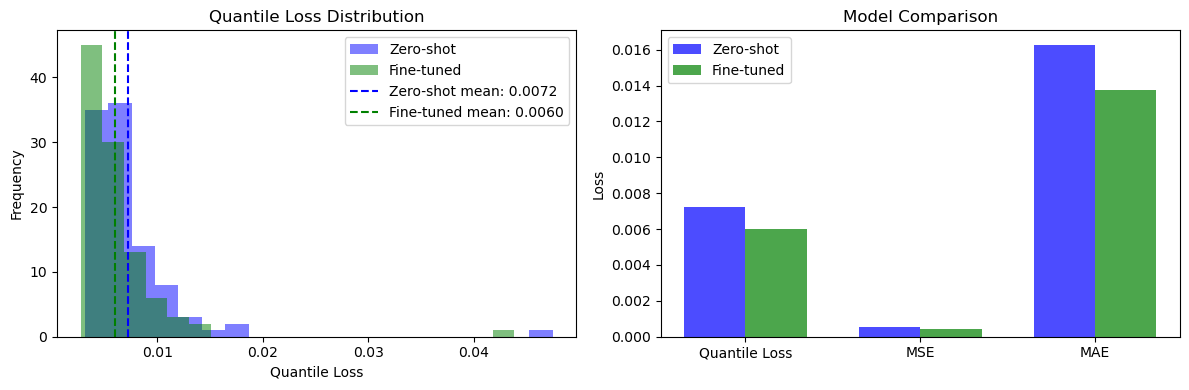

In [6]:
# Visualize loss distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Quantile loss distribution
axes[0].hist(baseline_results['quantile_losses'], bins=20, alpha=0.5, label='Zero-shot', color='blue')
axes[0].hist(finetuned_results['quantile_losses'], bins=20, alpha=0.5, label='Fine-tuned', color='green')
axes[0].axvline(baseline_results['mean_quantile_loss'], color='blue', linestyle='--', label=f"Zero-shot mean: {baseline_results['mean_quantile_loss']:.4f}")
axes[0].axvline(finetuned_results['mean_quantile_loss'], color='green', linestyle='--', label=f"Fine-tuned mean: {finetuned_results['mean_quantile_loss']:.4f}")
axes[0].set_xlabel('Quantile Loss')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Quantile Loss Distribution')
axes[0].legend()

# Bar chart comparison
metrics = ['Quantile Loss', 'MSE', 'MAE']
baseline_vals = [baseline_results['mean_quantile_loss'], baseline_results['mean_mse'], baseline_results['mean_mae']]
finetuned_vals = [finetuned_results['mean_quantile_loss'], finetuned_results['mean_mse'], finetuned_results['mean_mae']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1].bar(x - width/2, baseline_vals, width, label='Zero-shot', color='blue', alpha=0.7)
bars2 = axes[1].bar(x + width/2, finetuned_vals, width, label='Fine-tuned', color='green', alpha=0.7)
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()

plt.tight_layout()
plt.show()

In [1]:
# Run sliding backtest on evaluation data
results = run_chronos_sliding_backtest(
    pipeline=finetuned,
    df_returns=df_eval_clean,
    device=torch.device(get_device()),
    context_length=context_length,
)

print(summarize_backtest_results(results))

NameError: name 'run_chronos_sliding_backtest' is not defined

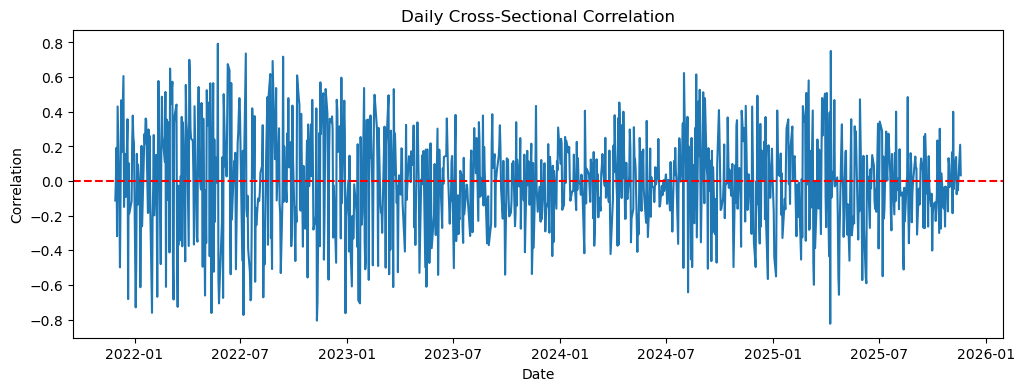

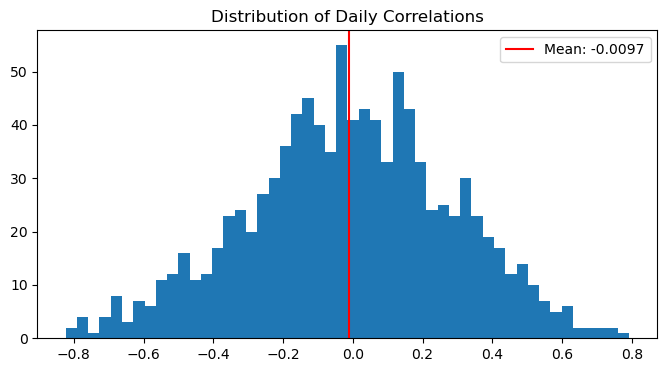

In [ ]:
# Detailed analysis
preds = results["preds"]   # (T_eval, N)
trues = results["trues"]   # (T_eval, N)
dates = results["dates"]

# Plot correlation over time
correlations = [m["corr"] for m in results["daily_metrics"]]
plt.figure(figsize=(12, 4))
plt.plot(dates, correlations)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Daily Cross-Sectional Correlation")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.show()

# Distribution of correlations
plt.figure(figsize=(8, 4))
plt.hist(correlations, bins=50)
plt.axvline(x=np.mean(correlations), color='r', label=f'Mean: {np.mean(correlations):.4f}')
plt.title("Distribution of Daily Correlations")
plt.legend()
plt.show()